In [191]:
import pandas as pd
import numpy as np
import scipy
import random
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight
from sklearn import preprocessing

### Load the grouped dataset

In [477]:
data = pd.read_csv('new_joined_data.csv')

In [250]:
pd.set_option('display.max_columns', None)
data.head()

ID_user   gender   age                      txn_time  \
0    21659     male   0.0     0 days 00:00:00.000000000   
1    98288     male  28.0   276 days 23:05:00.000000000   
2   105176  unknown   0.0  1095 days 17:09:00.000000000   
3   129407   female   0.0     0 days 00:00:00.000000000   
4   231743   female  33.0  1401 days 09:42:00.000000000   

   days_bw_first_last_txn  daysb/w_today_latest_txn     first_trans_date  \
0                       0                      1679  2010-09-27 17:45:00   
1                     276                        51  2014-06-09 21:58:00   
2                    1095                       156  2011-11-28 22:43:00   
3                       0                      1168  2012-02-20 17:02:00   
4                    1401                        31  2011-06-01 21:44:00   

       last_trans_date  txn_counts_unique  prod_counts_unique  txn_counts_all  \
0  2010-09-27 17:45:00                  1                   1               1   
1  2015-03-13 21:03:00                  5                   4               5   
2  2014-11-28 15:52:00                 10                   6              20   
3  2012-02-20 17:02:00                  1                   1               2   
4  2015-04-03 07:26:00                 30                  23              37   

   tot_sum_price  most_spent_prod_category  most_recent_prod_category  \
0         5187.0                      32.0                       32.0   
1        40573.0                     403.0                      459.0   
2        67301.0                     145.0                      227.0   
3        17940.0                     262.0                      262.0   
4       196547.0                     190.0                      200.0   

   spent_per_trans  most_recent_trans_month  most_recent_trans_year  
0      5187.000000                        9                    2010  
1      8114.600000                        3                    2015  
2      3365.050000                       11                    2014  
3      8970.000000                        2                    2012  
4      5312.081081                        4                    2015

In [251]:
data.sort_values('tot_sum_price', inplace=True, ascending=False)
data.reset_index(inplace=True, drop=True)
data.head(4)

ID_user  gender   age                      txn_time  \
0    8985038  female   0.0  1495 days 07:29:00.000000000   
1  174867143  female  59.0  1281 days 00:24:00.000000000   
2    9115418    male  38.0  1380 days 00:50:00.000000000   
3   53946950  female  43.0  1522 days 20:52:00.000000000   

   days_bw_first_last_txn  daysb/w_today_latest_txn     first_trans_date  \
0                    1495                       142  2010-11-08 10:01:00   
1                    1281                        26  2011-10-04 10:05:00   
2                    1380                       257  2010-11-08 12:59:00   
3                    1522                        35  2011-01-26 13:24:00   

       last_trans_date  txn_counts_unique  prod_counts_unique  txn_counts_all  \
0  2014-12-12 17:30:00                 72                  26             196   
1  2015-04-07 10:29:00                163                  78             317   
2  2014-08-19 13:49:00                258                  75             344   
3  2015-03-29 10:16:00                126                  41             212   

   tot_sum_price  most_spent_prod_category  most_recent_prod_category  \
0      2496286.0                     262.0                      490.0   
1      2154321.0                       NaN                      200.0   
2      2070991.0                     104.0                      154.0   
3      1510886.0                       NaN                      200.0   

   spent_per_trans  most_recent_trans_month  most_recent_trans_year  
0     12736.153061                       12                    2014  
1      6795.965300                        4                    2015  
2      6020.322674                        8                    2014  
3      7126.820755                        3                    2015

### Look for missing values

In [252]:
null_values = {}

for i in data.columns.values:
    if any(data.isnull()[i]):
        null_values[i] = data.isnull()[i].value_counts()
        
null_df = pd.DataFrame(null_values).T
null_df['index'] = null_df.index.values
null_df.reset_index(level=0, drop=True, inplace=True)
null_df = null_df.melt('index', var_name='T_F', value_name='NUM')
null_df

index    T_F   NUM
0                        age  False  6573
1   most_spent_prod_category  False  4737
2  most_recent_prod_category  False  4913
3                        age   True    10
4   most_spent_prod_category   True  1846
5  most_recent_prod_category   True  1670

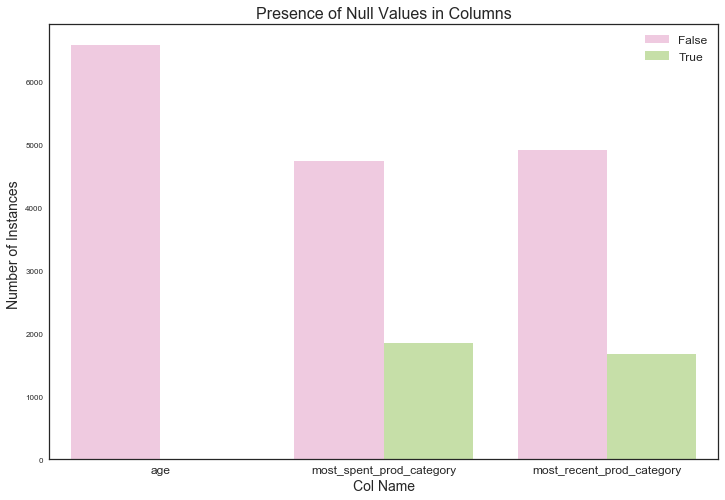

In [385]:
sns.barplot(x=null_df.iloc[:,0], y=null_df.iloc[:,2], hue=null_df.iloc[:,1], )
plt.title("Presence of Null Values in Columns", fontsize=16)
plt.xlabel('Col Name', fontsize=14)
plt.ylabel('Number of Instances ', fontsize=14)
plt.xticks(fontsize=12)
plt.rcParams["figure.figsize"] = [12,8]
plt.legend(fontsize=12)
#plt.xticks(rotation=90)
sns.set_style('white')
sns.set_palette('PiYG', 2)
#plt.show()
plt.savefig('null_plot.jpg')

### using nearest values to impute missing values for most_recent_prod_category and most_spent_prod_category

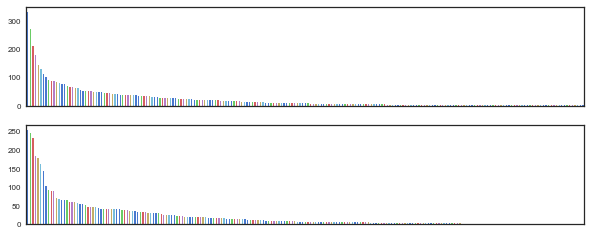

In [254]:
plt.subplot(2,1,1)
pl1 = data['most_recent_prod_category'].value_counts().plot(kind='bar', figsize=(10,4))
pl1.axes.get_xaxis().set_visible(False)

plt.subplot(2,1,2)
pl1 = data['most_spent_prod_category'].value_counts().plot(kind='bar', figsize=(10,4))
pl1.axes.get_xaxis().set_visible(False)

In [255]:
data['most_recent_prod_category'] = data['most_recent_prod_category'].fillna(method='ffill')

In [256]:
data['most_spent_prod_category'] = data['most_spent_prod_category'].fillna(method='ffill')

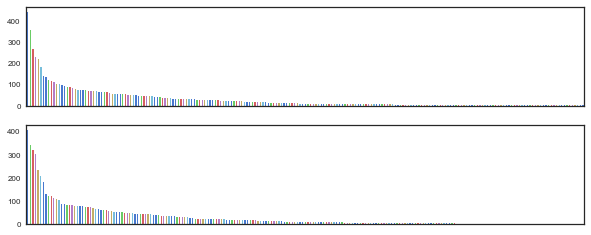

In [257]:
plt.subplot(2,1,1)
pl1 = data['most_recent_prod_category'].value_counts().plot(kind='bar', figsize=(10,4))
pl1.axes.get_xaxis().set_visible(False)

plt.subplot(2,1,2)
pl1 = data['most_spent_prod_category'].value_counts().plot(kind='bar', figsize=(10,4))
pl1.axes.get_xaxis().set_visible(False)

### handling missing values in age 
lot of missing values as zeros and also contains few number of nan

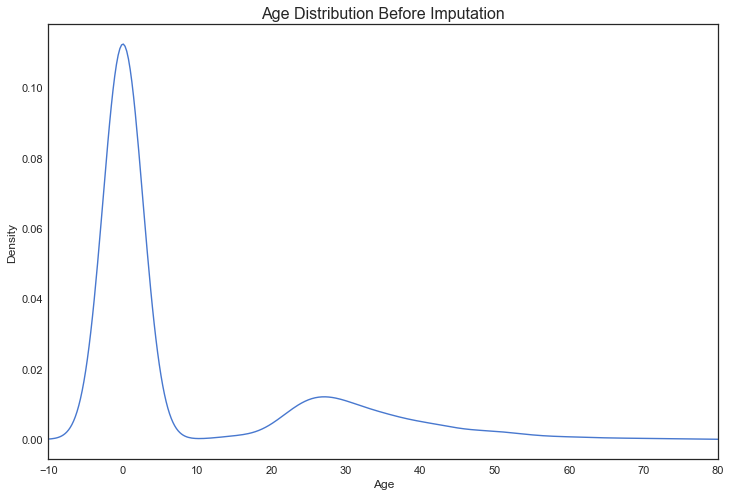

In [258]:
data['age'].plot(kind='density')
plt.title('Age Distribution Before Imputation', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlim(-10,80)
plt.savefig('age_before.jpg')

In [259]:
data['age'].fillna(method='ffill', inplace=True)

In [260]:
age_missing_x = data[data['age'] != 0][['tot_sum_price', 'txn_counts_unique', 'prod_counts_unique', 
                        'spent_per_trans', 'most_spent_prod_category']]
age_missing_x_predict = data[data['age'] == 0][['ID_user', 'tot_sum_price', 'txn_counts_unique', 'prod_counts_unique', 
                        'spent_per_trans', 'most_spent_prod_category']]
age_missing_y = data[data['age'] != 0][['age']]


age_knn = KNeighborsRegressor(n_neighbors=5, weights='distance', metric='euclidean')
age_knn.fit(age_missing_x, age_missing_y)
age_knn_missing_preds = age_knn.predict(age_missing_x_predict.iloc[:,1:])

In [261]:
data.loc[data['ID_user'].isin(age_missing_x_predict['ID_user'].values), 'age'] = age_knn_missing_preds

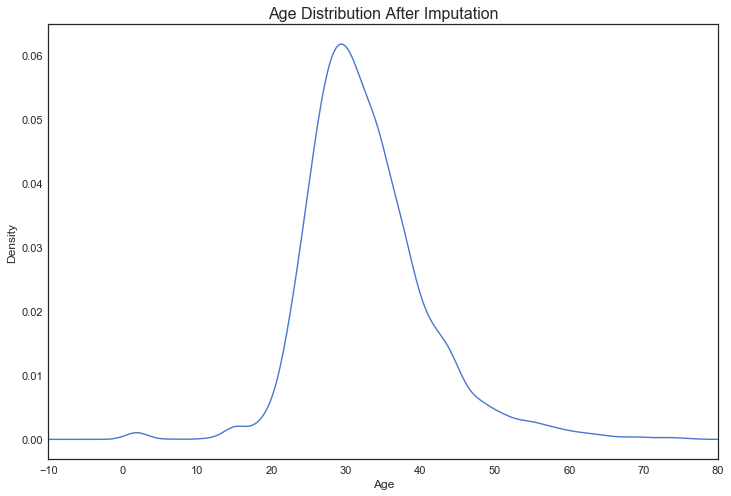

In [262]:
data['age'].plot('density')
plt.title('Age Distribution After Imputation', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlim(-10,80)
plt.savefig('age_after.jpg')

### Dealing with missing gender

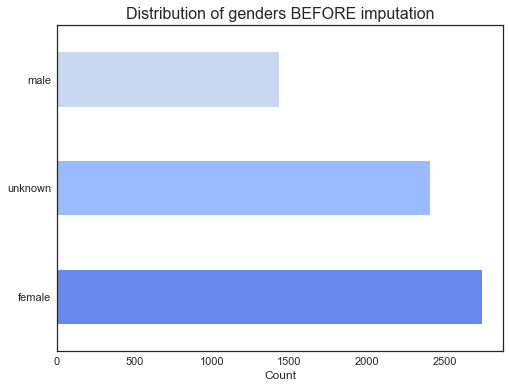

In [276]:
data['gender'].value_counts().plot(kind='barh', figsize=(8,6))
plt.title("Distribution of genders BEFORE imputation", fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
sns.set_palette('coolwarm')
plt.savefig('gender_before.jpg')

In [277]:
gender_missing_x = data[data['gender'] != 'unknown'][['tot_sum_price', 'txn_counts_unique', 'prod_counts_unique', 
                        'spent_per_trans', 'most_spent_prod_category', 'age']]
gender_missing_x_predict = data[data['gender'] == 'unknown'][['ID_user', 'tot_sum_price', 'txn_counts_unique', 
                                                              'prod_counts_unique', 'spent_per_trans', 
                                                              'most_spent_prod_category', 'age']]
gender_missing_y = data[data['gender'] != 'unknown'][['gender']]



#compute class weights because the classes are a little unbalanced
class_weight_vals = class_weight.compute_class_weight('balanced', np.unique(gender_missing_y['gender']), 
                                                      gender_missing_y['gender'])
class_weight_dict = {'female':class_weight_vals[0], 'male':class_weight_vals[1]}
class_weight_dict


gender_tree = DecisionTreeClassifier(criterion='gini', class_weight=class_weight_dict)
gender_tree.fit(gender_missing_x, gender_missing_y)
gender_tree_missing_preds = gender_tree.predict(gender_missing_x_predict.iloc[:,1:])

In [278]:
data.loc[data['ID_user'].isin(gender_missing_x_predict['ID_user'].values), 'gender'] = gender_tree_missing_preds

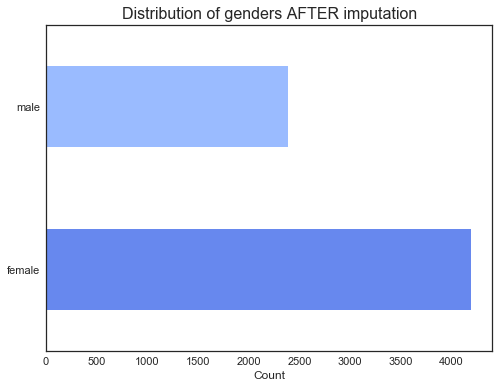

In [279]:
data['gender'].value_counts().plot(kind='barh', figsize=(8,6))
plt.title("Distribution of genders AFTER imputation", fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
sns.set_palette('coolwarm')
plt.savefig('gender_after.jpg')

In [280]:
data.head()

ID_user  gender        age                      txn_time  \
0    8985038  female  46.213898  1495 days 07:29:00.000000000   
1  174867143  female  59.000000  1281 days 00:24:00.000000000   
2    9115418    male  38.000000  1380 days 00:50:00.000000000   
3   53946950  female  43.000000  1522 days 20:52:00.000000000   
4  184235069  female  34.092336  1274 days 16:16:00.000000000   

   days_bw_first_last_txn  daysb/w_today_latest_txn     first_trans_date  \
0                    1495                       142  2010-11-08 10:01:00   
1                    1281                        26  2011-10-04 10:05:00   
2                    1380                       257  2010-11-08 12:59:00   
3                    1522                        35  2011-01-26 13:24:00   
4                    1274                         6  2011-10-30 19:54:00   

       last_trans_date  txn_counts_unique  prod_counts_unique  txn_counts_all  \
0  2014-12-12 17:30:00                 72                  26             196   
1  2015-04-07 10:29:00                163                  78             317   
2  2014-08-19 13:49:00                258                  75             344   
3  2015-03-29 10:16:00                126                  41             212   
4  2015-04-27 12:10:00                128                  52             168   

   tot_sum_price  most_spent_prod_category  most_recent_prod_category  \
0      2496286.0                     262.0                      490.0   
1      2154321.0                     262.0                      200.0   
2      2070991.0                     104.0                      154.0   
3      1510886.0                     104.0                      200.0   
4      1265108.0                     490.0                      200.0   

   spent_per_trans  most_recent_trans_month  most_recent_trans_year  
0     12736.153061                       12                    2014  
1      6795.965300                        4                    2015  
2      6020.322674                        8                    2014  
3      7126.820755                        3                    2015  
4      7530.404762                        4                    2015

### One hot encoding function

In [281]:
def do_one_hot_encoding(df_name, df_column_name, suffix=''):
    x = pd.get_dummies(df_name[df_column_name])
    df_name = df_name.join(x, lsuffix=suffix)
    df_name = df_name.drop(df_column_name, axis=1) 
    return df_name

### Label encoding function

In [282]:
def label_encoding_func(df_name, df_col_name):
    le = preprocessing.LabelEncoder()
    le.fit(df_name[df_col_name])
    return le.transform(df_name[df_col_name])

### get seasons from the dates
manually define seasons

In [283]:
from datetime import datetime, date

Y=2000
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(i):
    datetime_object = datetime.strptime(i, '%Y-%m-%d %H:%M:%S')
    date_object = datetime_object.date()
    #Y = get_year(i)
    date_object = date_object.replace(year=Y)
    return next(season for season, (start, end) in seasons if start <= date_object <= end)

def get_year(i):
    datetime_object = datetime.strptime(i, '%Y-%m-%d %H:%M:%S')
    return datetime_object.year

In [284]:
data['first_trans_season'] = data['first_trans_date'].apply(get_season)
data['first_trans_season'] = label_encoding_func(data, 'first_trans_season')

In [285]:
data['last_trans_season'] = data['last_trans_date'].apply(get_season)
data['last_trans_season'] = label_encoding_func(data, 'last_trans_season')

Average number of days between transactions

In [286]:
data['avg_days_bw_txns'] = round(data['days_bw_first_last_txn']/data['txn_counts_all'],2)

In [287]:
data.head()

ID_user  gender        age                      txn_time  \
0    8985038  female  46.213898  1495 days 07:29:00.000000000   
1  174867143  female  59.000000  1281 days 00:24:00.000000000   
2    9115418    male  38.000000  1380 days 00:50:00.000000000   
3   53946950  female  43.000000  1522 days 20:52:00.000000000   
4  184235069  female  34.092336  1274 days 16:16:00.000000000   

   days_bw_first_last_txn  daysb/w_today_latest_txn     first_trans_date  \
0                    1495                       142  2010-11-08 10:01:00   
1                    1281                        26  2011-10-04 10:05:00   
2                    1380                       257  2010-11-08 12:59:00   
3                    1522                        35  2011-01-26 13:24:00   
4                    1274                         6  2011-10-30 19:54:00   

       last_trans_date  txn_counts_unique  prod_counts_unique  txn_counts_all  \
0  2014-12-12 17:30:00                 72                  26             196   
1  2015-04-07 10:29:00                163                  78             317   
2  2014-08-19 13:49:00                258                  75             344   
3  2015-03-29 10:16:00                126                  41             212   
4  2015-04-27 12:10:00                128                  52             168   

   tot_sum_price  most_spent_prod_category  most_recent_prod_category  \
0      2496286.0                     262.0                      490.0   
1      2154321.0                     262.0                      200.0   
2      2070991.0                     104.0                      154.0   
3      1510886.0                     104.0                      200.0   
4      1265108.0                     490.0                      200.0   

   spent_per_trans  most_recent_trans_month  most_recent_trans_year  \
0     12736.153061                       12                    2014   
1      6795.965300                        4                    2015   
2      6020.322674                        8                    2014   
3      7126.820755                        3                    2015   
4      7530.404762                        4                    2015   

   first_trans_season  last_trans_season  avg_days_bw_txns  
0                   0                  0              7.63  
1                   0                  1              4.04  
2                   0                  2              4.01  
3                   3                  1              7.18  
4                   0                  1              7.58

# Segmentation Models Start From Here

In [288]:
cluster_data = pd.read_csv('new_joined_clean_data_1.csv')

In [289]:
cluster_data.head()

ID_user  gender        age                      txn_time  \
0    8985038  female  46.213898  1495 days 07:29:00.000000000   
1  174867143  female  59.000000  1281 days 00:24:00.000000000   
2    9115418    male  38.000000  1380 days 00:50:00.000000000   
3   53946950  female  43.000000  1522 days 20:52:00.000000000   
4  184235069  female  34.092336  1274 days 16:16:00.000000000   

   days_bw_first_last_txn  daysb/w_today_latest_txn     first_trans_date  \
0                    1495                       142  2010-11-08 10:01:00   
1                    1281                        26  2011-10-04 10:05:00   
2                    1380                       257  2010-11-08 12:59:00   
3                    1522                        35  2011-01-26 13:24:00   
4                    1274                         6  2011-10-30 19:54:00   

       last_trans_date  txn_counts_unique  prod_counts_unique  txn_counts_all  \
0  2014-12-12 17:30:00                 72                  26             196   
1  2015-04-07 10:29:00                163                  78             317   
2  2014-08-19 13:49:00                258                  75             344   
3  2015-03-29 10:16:00                126                  41             212   
4  2015-04-27 12:10:00                128                  52             168   

   tot_sum_price  most_spent_prod_category  most_recent_prod_category  \
0      2496286.0                     262.0                      490.0   
1      2154321.0                     262.0                      200.0   
2      2070991.0                     104.0                      154.0   
3      1510886.0                     104.0                      200.0   
4      1265108.0                     490.0                      200.0   

   spent_per_trans  most_recent_trans_month  most_recent_trans_year  \
0     12736.153061                       12                    2014   
1      6795.965300                        4                    2015   
2      6020.322674                        8                    2014   
3      7126.820755                        3                    2015   
4      7530.404762                        4                    2015   

   first_trans_season  last_trans_season  avg_days_bw_txns  
0                   0                  0              7.63  
1                   0                  1              4.04  
2                   0                  2              4.01  
3                   3                  1              7.18  
4                   0                  1              7.58

### customer segmentation using k-means
loosely based on recency, frequency and monetary measures of each customer

In [31]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [32]:
cluster_x_data = cluster_data[['ID_user','days_bw_first_last_txn', 'daysb/w_today_latest_txn', 'avg_days_bw_txns', 
                               'tot_sum_price', 'spent_per_trans', 'most_recent_trans_year', 'most_recent_trans_month', 
                              'txn_counts_unique', 'prod_counts_unique']]

explore the data to be used for clustering

C:\Users\User\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


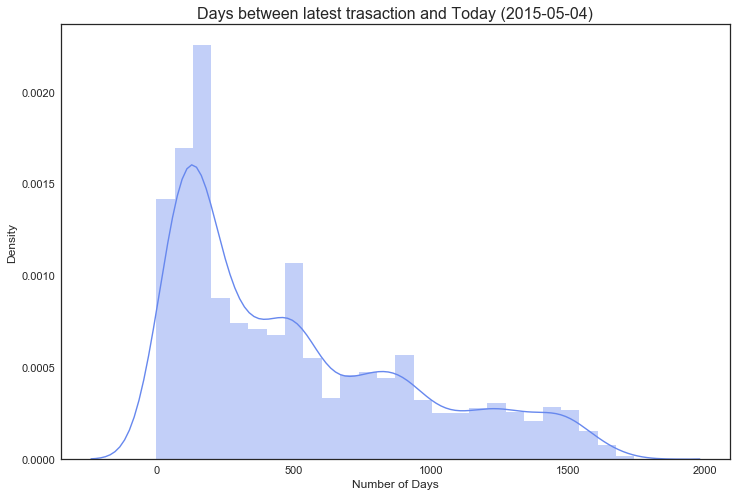

In [312]:
sns.distplot(cluster_x_data['daysb/w_today_latest_txn'])
plt.title('Days between latest trasaction and Today (2015-05-04)', fontsize=16)
plt.xlabel('Number of Days', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
sns.set_palette('coolwarm')
sns.set_style('white')
plt.savefig('days_bw_today_latest.jpg')

C:\Users\User\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


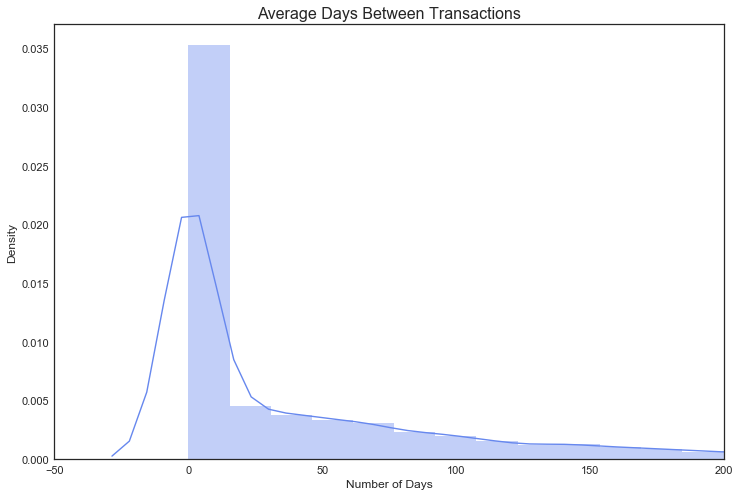

In [332]:
sns.distplot(cluster_x_data['avg_days_bw_txns'])
plt.title('Average Days Between Transactions', fontsize=16)
plt.xlabel('Number of Days', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlim(-50, 200)
sns.set_palette('coolwarm')
sns.set_style('white')
plt.savefig('avg_days_bw_txn.jpg')

C:\Users\User\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


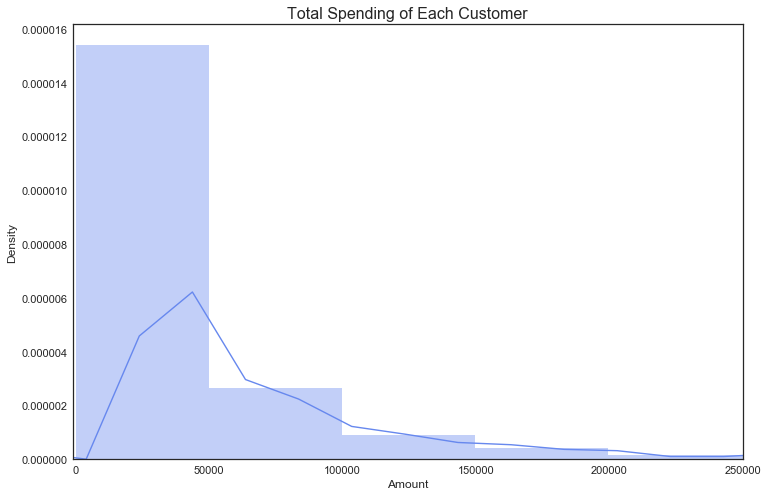

In [375]:
sns.distplot(cluster_x_data['tot_sum_price'])
plt.title('Total Spending of Each Customer', fontsize=16)
plt.xlabel('Amount', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
sns.set_palette('coolwarm')
sns.set_style('white')
plt.xlim(-1000, 250000)
plt.savefig('total_spending_each_customer.jpg')

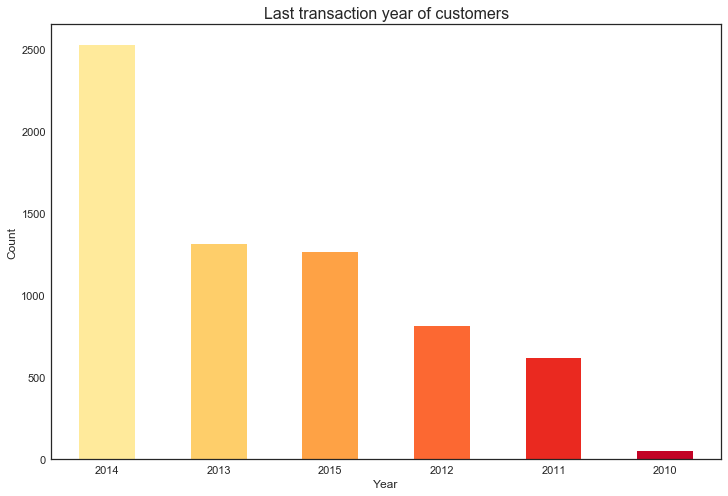

In [377]:
cluster_x_data['most_recent_trans_year'].value_counts().plot(kind='bar')
plt.title('Last transaction year of customers', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation=360)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
sns.set_palette('YlOrRd')
plt.savefig('last_trans_year.jpg')

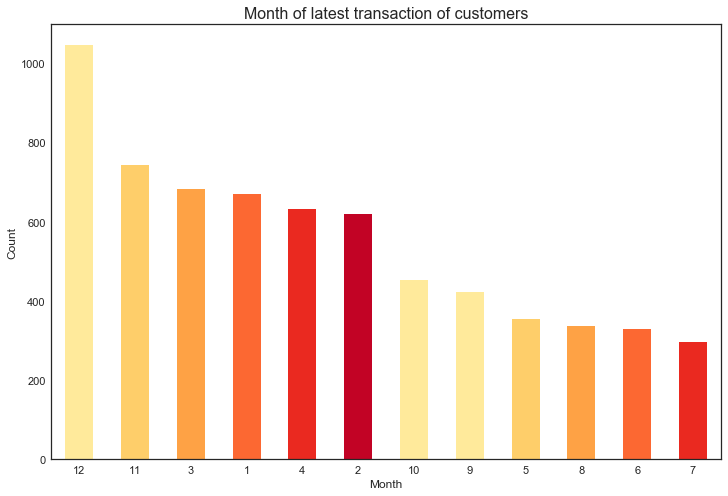

In [361]:
cluster_x_data['most_recent_trans_month'].value_counts().plot(kind='bar')
plt.title('Month of latest transaction of customers', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.xticks(rotation=360)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
sns.set_palette('YlOrRd')
plt.savefig('last_trans_month.jpg')

first scale the data and do k-means clustering

In [38]:
std_scaler = StandardScaler()
cluster_x_scaled = pd.DataFrame(std_scaler.fit_transform(cluster_x_data.iloc[:, 1:]))
cluster_x_scaled.head()

0         1         2          3         4         5         6  \
0  2.607106 -0.838452 -0.496588  25.690548  0.234195  0.456968  1.352468   
1  2.131342 -1.105434 -0.537135  22.108669 -0.213218  1.265195 -0.685308   
2  2.351438 -0.573771 -0.537474  21.235837 -0.271639  0.456968  0.333580   
3  2.667132 -1.084720 -0.501670  15.369072 -0.188298  1.265195 -0.940030   
4  2.115780 -1.151465 -0.497152  12.794695 -0.157900  1.265195 -0.685308   

           7          8  
0   7.125425   5.386047  
1  16.711910  17.382782  
2  26.719779  16.690663  
3  12.814108   8.846644  
4  13.024800  11.384415

In [39]:
sum_squared_errors = {}
for i in range(2,7):
    cluster = KMeans(n_clusters=i).fit(cluster_x_scaled)
    label = cluster.labels_
    sil_coeff = silhouette_score(cluster_x_scaled, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(i, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.3128086428206776
For n_clusters=3, The Silhouette Coefficient is 0.2567421556266821
For n_clusters=4, The Silhouette Coefficient is 0.2740082256947769
For n_clusters=5, The Silhouette Coefficient is 0.28273548272960586
For n_clusters=6, The Silhouette Coefficient is 0.29985382356993795


In [40]:
cluster = KMeans(n_clusters=3, random_state=1)
cluster_x_data['cluster'] = cluster.fit_predict(cluster_x_scaled)
cluster_x_data.cluster.value_counts()

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0    4345
1    2141
2      97
Name: cluster, dtype: int64

In [41]:
cluster_x_data.head()

ID_user  days_bw_first_last_txn  daysb/w_today_latest_txn  \
0    8985038                    1495                       142   
1  174867143                    1281                        26   
2    9115418                    1380                       257   
3   53946950                    1522                        35   
4  184235069                    1274                         6   

   avg_days_bw_txns  tot_sum_price  spent_per_trans  most_recent_trans_year  \
0              7.63      2496286.0     12736.153061                    2014   
1              4.04      2154321.0      6795.965300                    2015   
2              4.01      2070991.0      6020.322674                    2014   
3              7.18      1510886.0      7126.820755                    2015   
4              7.58      1265108.0      7530.404762                    2015   

   most_recent_trans_month  txn_counts_unique  prod_counts_unique  cluster  
0                       12                 72                  26        2  
1                        4                163                  78        2  
2                        8                258                  75        2  
3                        3                126                  41        2  
4                        4                128                  52        2

Eplore the clustered data

In [42]:
cluster_x_data_1 = cluster_x_data[cluster_x_data['cluster']==0]
cluster_x_data_2 = cluster_x_data[cluster_x_data['cluster']==1]
cluster_x_data_3 = cluster_x_data[cluster_x_data['cluster']==2]
#cluster_x_data_4 = cluster_x_data[cluster_x_data['cluster']==3]

In [43]:
cluster_x_data_1.describe()

ID_user  days_bw_first_last_txn  daysb/w_today_latest_txn  \
count  4.345000e+03             4345.000000               4345.000000   
mean   2.462074e+10               49.827618                659.316686   
std    3.390862e+10              117.851332                446.890060   
min    2.165900e+04                0.000000                  2.000000   
25%    1.682891e+08                0.000000                254.000000   
50%    3.473199e+08                0.000000                567.000000   
75%    4.583358e+10               13.000000                974.000000   
max    9.744034e+10              819.000000               1742.000000   

       avg_days_bw_txns  tot_sum_price  spent_per_trans  \
count       4345.000000    4345.000000      4345.000000   
mean          12.118914   20424.189597     10765.936808   
std           29.084962   29954.464502     15441.769243   
min            0.000000      13.000000        13.000000   
25%            0.000000    4134.000000      2587.000000   
50%            0.000000    9100.000000      4667.000000   
75%            3.670000   25870.000000     11622.000000   
max          260.000000  414960.000000    259987.000000   

       most_recent_trans_year  most_recent_trans_month  txn_counts_unique  \
count             4345.000000              4345.000000        4345.000000   
mean              2012.993556                 6.949367           1.588262   
std                  1.235768                 3.822273           1.273255   
min               2010.000000                 1.000000           1.000000   
25%               2012.000000                 3.000000           1.000000   
50%               2013.000000                 7.000000           1.000000   
75%               2014.000000                11.000000           2.000000   
max               2015.000000                12.000000          17.000000   

       prod_counts_unique  cluster  
count         4345.000000   4345.0  
mean             1.131876      0.0  
std              0.983922      0.0  
min              0.000000      0.0  
25%              1.000000      0.0  
50%              1.000000      0.0  
75%              1.000000      0.0  
max             10.000000      0.0

In [44]:
cluster_x_data_2.describe()

ID_user  days_bw_first_last_txn  daysb/w_today_latest_txn  \
count  2.141000e+03             2141.000000               2141.000000   
mean   6.914441e+09              830.430640                214.791219   
std    1.793795e+10              370.920698                185.102005   
min    9.828800e+04               79.000000                  0.000000   
25%    9.858377e+07              531.000000                 82.000000   
50%    1.923533e+08              800.000000                150.000000   
75%    3.430260e+08             1118.000000                307.000000   
max    8.836419e+10             1686.000000                988.000000   

       avg_days_bw_txns  tot_sum_price  spent_per_trans  \
count       2141.000000    2141.000000      2141.000000   
mean         133.238314   66831.828118      7458.498767   
std          111.847669   67470.432814      7074.199339   
min            5.450000    1144.000000       455.000000   
25%           55.000000   20098.000000      3280.333333   
50%           99.300000   44460.000000      5087.333333   
75%          174.500000   89830.000000      8783.666667   
max          768.000000  597753.000000     71053.666667   

       most_recent_trans_year  most_recent_trans_month  txn_counts_unique  \
count             2141.000000              2141.000000        2141.000000   
mean              2014.269033                 6.265764           7.447454   
std                  0.653187                 4.095346           6.529349   
min               2012.000000                 1.000000           2.000000   
25%               2014.000000                 3.000000           3.000000   
50%               2014.000000                 5.000000           5.000000   
75%               2015.000000                11.000000           9.000000   
max               2015.000000                12.000000          41.000000   

       prod_counts_unique  cluster  
count         2141.000000   2141.0  
mean             4.638487      1.0  
std              3.686182      0.0  
min              0.000000      1.0  
25%              2.000000      1.0  
50%              3.000000      1.0  
75%              6.000000      1.0  
max             23.000000      1.0

In [45]:
cluster_x_data_3.describe()

ID_user  days_bw_first_last_txn  daysb/w_today_latest_txn  \
count  9.700000e+01               97.000000                 97.000000   
mean   1.009788e+09             1312.896907                 85.989691   
std    5.270507e+09              261.616150                104.602172   
min    2.317430e+05              435.000000                  3.000000   
25%    2.881953e+07             1179.000000                 23.000000   
50%    1.018738e+08             1391.000000                 53.000000   
75%    1.748671e+08             1508.000000                108.000000   
max    3.831763e+10             1753.000000                513.000000   

       avg_days_bw_txns  tot_sum_price  spent_per_trans  \
count         97.000000   9.700000e+01        97.000000   
mean          17.972371   5.681174e+05      6460.103913   
std            8.270891   4.106216e+05      2900.202827   
min            4.010000   1.433510e+05      2275.412698   
25%           11.560000   3.211260e+05      4274.198276   
50%           18.370000   4.498390e+05      6430.840000   
75%           23.350000   6.459960e+05      7851.000000   
max           46.490000   2.496286e+06     18102.500000   

       most_recent_trans_year  most_recent_trans_month  txn_counts_unique  \
count               97.000000                97.000000          97.000000   
mean              2014.773196                 4.463918          60.484536   
std                  0.467822                 3.136020          37.579115   
min               2013.000000                 1.000000          15.000000   
25%               2015.000000                 3.000000          38.000000   
50%               2015.000000                 4.000000          47.000000   
75%               2015.000000                 4.000000          72.000000   
max               2015.000000                12.000000         258.000000   

       prod_counts_unique  cluster  
count           97.000000     97.0  
mean            27.041237      2.0  
std             12.166311      0.0  
min             11.000000      2.0  
25%             20.000000      2.0  
50%             23.000000      2.0  
75%             30.000000      2.0  
max             78.000000      2.0

Cluster Distribution

Per transaction spending

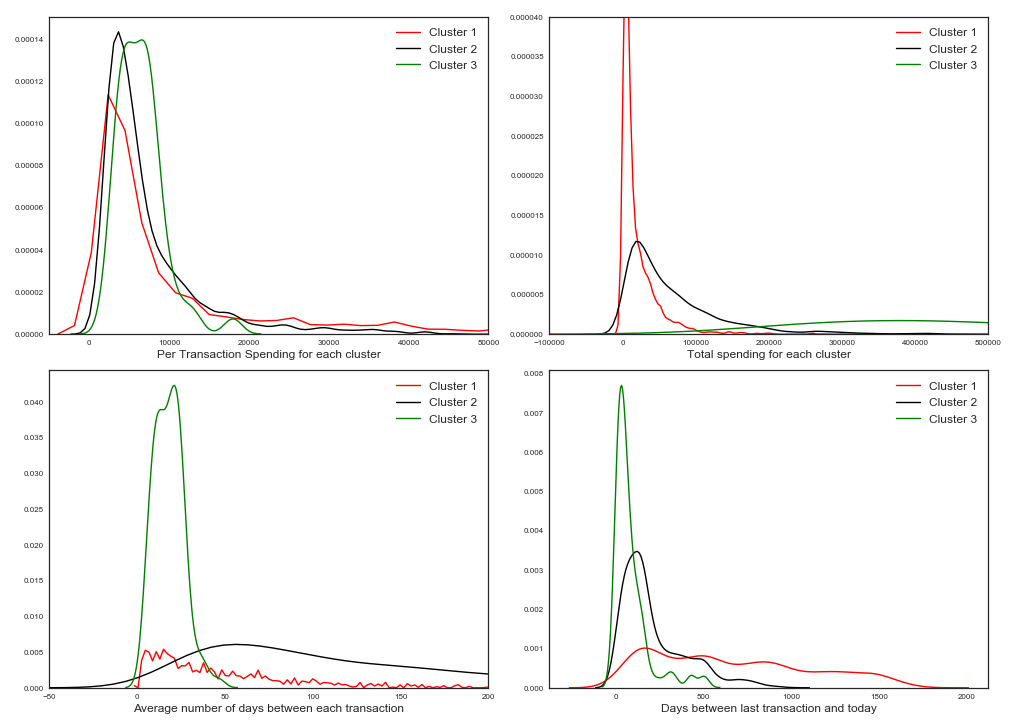

In [403]:
plt.rcParams["figure.figsize"] = [14,10]

plt.subplot(2,2,1)
sns.distplot(cluster_x_data_1['spent_per_trans'], hist=False, kde=True, label='Cluster 1', color='red')
sns.distplot(cluster_x_data_2['spent_per_trans'], hist=False, kde=True, label='Cluster 2', color='black')
sns.distplot(cluster_x_data_3['spent_per_trans'], hist=False, kde=True, label='Cluster 3', color='green')
#sns.distplot(cluster_x_data_4['spent_per_trans'], hist=False, kde=True, label='4')
plt.xlabel("Per Transaction Spending for each cluster", fontsize=12)
plt.legend(fontsize=12)
plt.xlim(-5000, 50000)

plt.subplot(2,2,2)
sns.distplot(cluster_x_data_1['tot_sum_price'], hist=False, kde=True, label='Cluster 1', color='red')
sns.distplot(cluster_x_data_2['tot_sum_price'], hist=False, kde=True, label='Cluster 2', color='black')
sns.distplot(cluster_x_data_3['tot_sum_price'], hist=False, kde=True, label='Cluster 3', color='green')
#sns.distplot(cluster_x_data_4['tot_sum_price'], hist=False, kde=True, label='4')
plt.xlabel("Total spending for each cluster", fontsize=12)
plt.legend(fontsize=12)
plt.xlim(-100000, 500000)
plt.ylim(0, 0.00004)

plt.subplot(2,2,3)
sns.distplot(cluster_x_data_1['avg_days_bw_txns'], hist=False, kde=True, label='Cluster 1', color='red')
sns.distplot(cluster_x_data_2['avg_days_bw_txns'], hist=False, kde=True, label='Cluster 2', color='black')
sns.distplot(cluster_x_data_3['avg_days_bw_txns'], hist=False, kde=True, label='Cluster 3', color='green')
#sns.distplot(cluster_x_data_4['avg_days_bw_txns'], hist=False, kde=True, label='4')
plt.xlabel("Average number of days between each transaction", fontsize=12)
plt.legend(fontsize=12)
plt.xlim(-50, 200)

plt.subplot(2,2,4)
sns.distplot(cluster_x_data_1['daysb/w_today_latest_txn'], hist=False, kde=True, label='Cluster 1', color='red')
sns.distplot(cluster_x_data_2['daysb/w_today_latest_txn'], hist=False, kde=True, label='Cluster 2', color='black')
sns.distplot(cluster_x_data_3['daysb/w_today_latest_txn'], hist=False, kde=True, label='Cluster 3', color='green')
plt.xlabel("Days between last transaction and today", fontsize=12)
plt.legend(fontsize=12)

plt.rcParams['figure.constrained_layout.use'] = True
plt.tight_layout()
plt.savefig('segmentation1.jpg')

Total spending

Average days between transactions

Days between today and last transaction

C:\Users\User\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\User\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\User\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


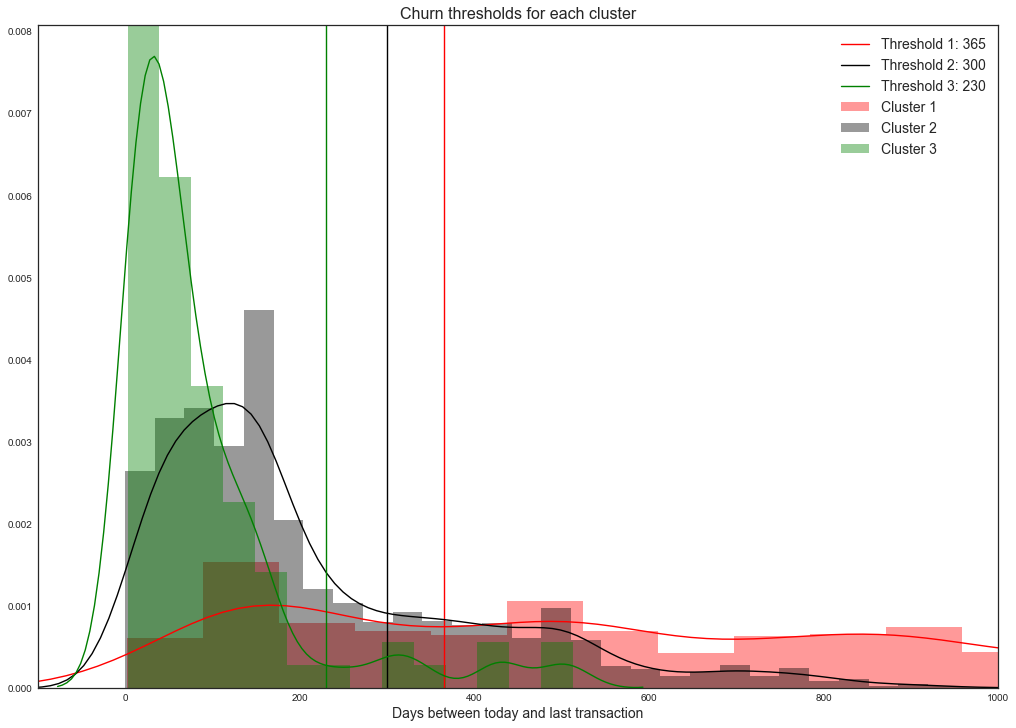

In [415]:
plt.title('Churn thresholds for each cluster', fontsize=16)
sns.distplot(cluster_x_data_1['daysb/w_today_latest_txn'], hist=True, kde=True, label='Cluster 1', color='red',
            hist_kws={"linewidth": 3,"alpha": 0.4})
plt.axvline(x=365, color='red', label="Threshold 1: 365")
sns.distplot(cluster_x_data_2['daysb/w_today_latest_txn'], hist=True, kde=True, label='Cluster 2', color='black',
            hist_kws={"linewidth": 3,"alpha": 0.4})
plt.axvline(x=300, color='black', label="Threshold 2: 300")
sns.distplot(cluster_x_data_3['daysb/w_today_latest_txn'], hist=True, kde=True, label='Cluster 3', color='green',
            hist_kws={"linewidth": 3,"alpha": 0.4})
plt.axvline(x=230, color='green', label="Threshold 3: 230")
plt.xlabel('Days between today and last transaction', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=14)
plt.xlim(-100, 1000)
sns.set_context('paper')
plt.savefig('segmentation_churn_thres.jpg')

#### set labels for churn and join the dataset

In [106]:
cluster_assignments = cluster_x_data[['ID_user', 'cluster']]

In [159]:
NEW_DATA = cluster_data.merge(cluster_assignments, on='ID_user')

In [160]:
NEW_DATA['churn'] = [0]*len(NEW_DATA)

In [164]:
NEW_DATA.loc[(NEW_DATA['cluster'] == 0) & (NEW_DATA['daysb/w_today_latest_txn'] > 365), 'churn'] = 1

In [165]:
NEW_DATA.loc[(NEW_DATA['cluster'] == 1) & (NEW_DATA['daysb/w_today_latest_txn'] > 300), 'churn'] = 1

In [166]:
NEW_DATA.loc[(NEW_DATA['cluster'] == 2) & (NEW_DATA['daysb/w_today_latest_txn'] > 230), 'churn'] = 1

Extract year of first transaction from date

In [171]:
def convert_to_datetime_get_year(txn_time):
    datetime_object = datetime.strptime(txn_time, '%Y-%m-%d %H:%M:%S')
    return datetime_object.year

In [172]:
NEW_DATA['first_trans_year'] = NEW_DATA['first_trans_date'].apply(convert_to_datetime_get_year)

Save the new dataset as csv and use it for building models

#### Plot Churn Label Distribution

In [427]:
clus_df = pd.read_csv('churn_labels_new_data.csv')

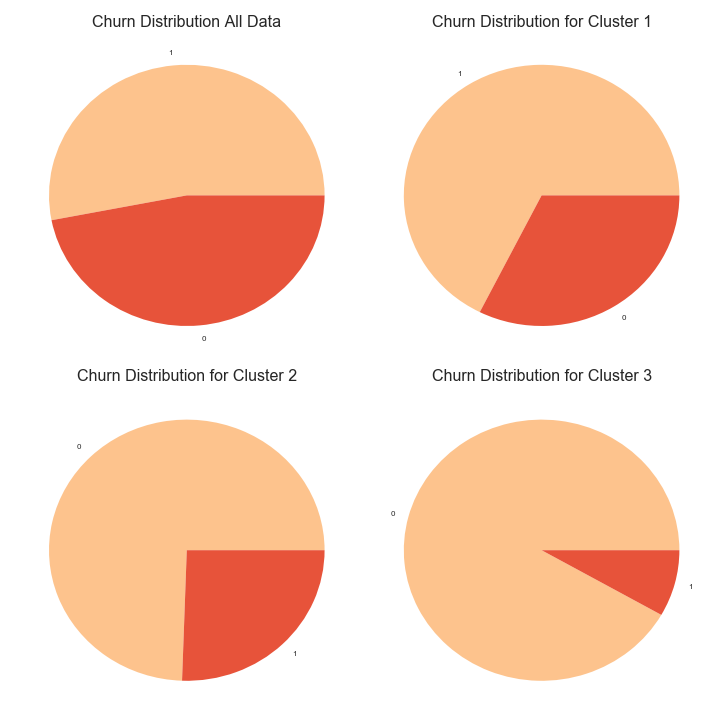

In [476]:
plt.rcParams["figure.figsize"] = [10,10]
plt.subplot(2,2,1)
plt.rcParams["figure.figsize"] = [8,8]
clus_df['churn'].value_counts().plot(kind='pie')
plt.title('Churn Distribution All Data', fontsize=16)
sns.set_palette('OrRd', 2)
plt.ylabel('')

plt.subplot(2,2,2)
plt.rcParams["figure.figsize"] = [8,8]
clus_df.loc[clus_df['cluster']==0, 'churn'].value_counts().plot(kind='pie')
plt.title('Churn Distribution for Cluster 1', fontsize=16)
sns.set_palette('OrRd', 2)
plt.ylabel('')

plt.subplot(2,2,3)
plt.rcParams["figure.figsize"] = [8,8]
clus_df.loc[clus_df['cluster']==1, 'churn'].value_counts().plot(kind='pie')
plt.title('Churn Distribution for Cluster 2', fontsize=16)
sns.set_palette('OrRd', 2)
plt.ylabel('')

plt.subplot(2,2,4)
plt.rcParams["figure.figsize"] = [8,8]
clus_df.loc[clus_df['cluster']==2, 'churn'].value_counts().plot(kind='pie')
plt.title('Churn Distribution for Cluster 3', fontsize=16)
sns.set_palette('OrRd', 2)
plt.ylabel('')

plt.tight_layout()
plt.savefig('churn_dist.jpg')

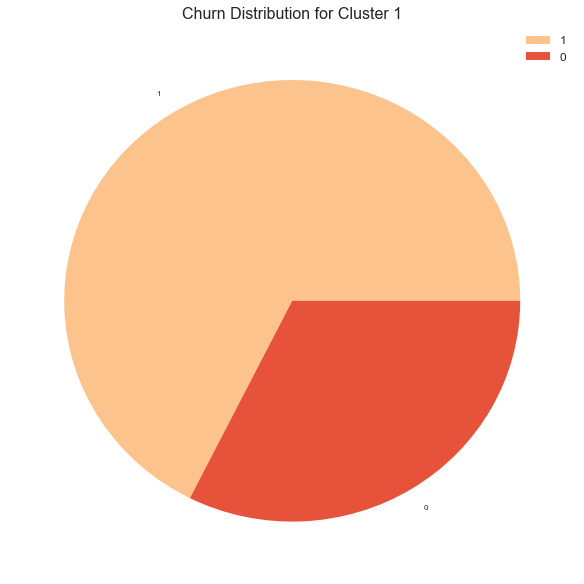

In [455]:
plt.rcParams["figure.figsize"] = [8,8]
clus_df.loc[clus_df['cluster']==0, 'churn'].value_counts().plot(kind='pie')
plt.title('Churn Distribution for Cluster 1', fontsize=16)
plt.legend(fontsize=12)
sns.set_palette('OrRd', 2)
plt.ylabel('')
plt.savefig('churn_dist1.jpg')